In [1]:
# Import general packages
import sys
import os
import re
import glob
import json
import gzip
import itertools
from tqdm.auto import tqdm
import copy
from pathlib import PurePath

# Parallel processing
from joblib import Parallel, delayed

# import data and math packages
import numpy as np
import pandas as pd
from pandarallel import pandarallel
 
import networkx as nx
import matplotlib.pyplot as plt

from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

from abnumber import Chain
from abnumber.exceptions import ChainParseError, MultipleDomainsChainParseError

# working with structures
import prody as pr
import pymol as pml

import requests
# Working with sequences
import pyfastx
import swalign
# choose your own values here… 2 and -1 are common.
match = 2#
mismatch = -1
scoring = swalign.NucleotideScoringMatrix(match, mismatch)
sw = swalign.LocalAlignment(scoring)  # you can also choose gap penalties, etc...

import torch
from allennlp.commands.elmo import ElmoEmbedder
from pathlib import Path

model_dir = Path('/nfs/baron1/nolde/zhalevsky/uniref50_v2/')  # Seqvec data
weights = model_dir / 'weights.hdf5'
options = model_dir / 'options.json'
seqvec  = ElmoEmbedder(options,weights,cuda_device=0) # cuda_device=-1 for CPU

import Bio.PDB 
import Bio.PDB.ccealign
from Bio.PDB.ccealign import run_cealign

# Part 2

In [2]:
# Read covadab with CDRs
# Select only human Abs
# Extract pdbids
# Add pdbids from rcsb search:
#      Scientific Name of the Source Organism is Severe acute respiratory syndrome coronavirus 2 AND
#      Scientific Name of the Source Organism is Homo Sapiens AND
#      Title has any of words (antibody, antibodies, Fab, Fabs)
# Download pdb structures from the rcsb sever
# For structures of human antibodies in the covadab database process structure file to 
# find Abs H and L chain and RBD chain
# split pdb file to H+L+RBD chains and H+L chains only fitted to reference RBD structure
# Process pdb files which are not in the covadb database
# Fit Ab-RBD to ref complex and calculates decart coordinates of 3 points for Ab
#          1. center of mass of RBD heavy atoms interacting with Ab
#          2. center of mass of Ab heavy atoms interacting with RBD
#          3. center of CA atoms of Av variable domain
# Write unfiltered database
# Drop Ab not interacting with RBD (residue 319-541) and write next database version
# Calculate Seqvec embedded vectors for CDR[HL][1-3] and plot distance 
# between embedded vectors vs distance between epitopes map
# Delete outliers based on plotted map and save the database
# Drop duplicates on set of 6 RBD sequences (keep only las entry)
# 

In [3]:
# I/O files locataion
datadir = '/nfs/baron1/nolde/zhalevsky/covidmap_v16' # path to I/O directory
dbfname = 'covadab_allcdr.json'                     # input file (output of part 1)
newpdblist = 'list2.txt'                            # file with additional pdbids (see cell above)
ref_rbd = 'ref.pdb'                                  # reference RBD structure from pdb 7LOP
ref_fn = str(PurePath(datadir, ref_rbd))
ref_ace = 'ace2.pdb'                                 # Ace2 structure of Ace2-RBD complex (6m0j) fitted to refrbd
ace2_fn = str(PurePath(datadir, ref_ace))
pdbrawdir = str(PurePath(datadir, 'pdb_raw'))         # Directory to download pdb files
pdbcleandir = str(PurePath(datadir, 'pdb_clean'))     # Store only RBD and 2 Ab chains
pdbabdir = str(PurePath(datadir, 'pdb_clean_ab_only')) #  Store only Abs chains
rbdseqs = 'rbd_seqs.fasta'                            # Output all RBD sequences
outfile1 = 'covidab_pdb_rbd_p1.json'                  # Output nonfiltered database with duplicates, non-rbd bindings etc
outfile2 = 'covidab_pdb_rbd_p2.json'                  # Output filtered for complexes binds with RBD
outfile3 = 'covidab_pdb_rbd_p3.json'                  # Output filtered for outliers based on Seqvec-Epitope distances map
outfile4 = 'covidab_pdb_rbd_p4.json'                  # Output filtered for Ab with unique CDRHL[1-3] sequences

In [4]:
covadab = pd.read_json(PurePath(datadir, dbfname))

In [5]:
# filter entries containing pdb structure
covadab['Structures'] = covadab['Structures'].str.upper()
covadab_pdb = covadab[covadab['Structures'].str.contains('WWW') == True].copy()
print(len(covadab_pdb))

516


In [6]:
### IMPORTANT PART ###
# SELECT ONLY HUMAN ABs vs RBD
hrbds = covadab_pdb[
    (covadab_pdb['Binds to'].str.contains('SARS-CoV2')) & 
    (covadab_pdb['Protein + Epitope'] == 'S; RBD') &
    (covadab_pdb['Heavy V Gene'].str.contains('Human')) &
    (covadab_pdb['Light V Gene'].str.contains('Human'))]

In [7]:
qid = re.compile('[1-9][0-9A-Za-z]{3}')
pdbids = list()
for index, row in hrbds.iterrows():
    pdbs = row['Structures']
    q = qid.findall(pdbs)
    if q is None:
        print(row)
    else:
        pdbids.extend(q)
        
pdbids = set(pdbids)

In [8]:
print(len(pdbids))

584


In [9]:
# Additional pdbids
with open(PurePath(datadir, newpdblist), 'r') as f1:
    newids = set(f1.readline()[:-1].split(','))
#pdbids = list(set(pdbids+list1))
#print(len(pdbids))
pdbids = pdbids.union(newids)
print(len(pdbids))

773


In [10]:
print(covadab_pdb.keys())

Index(['Name', 'Ab or Nb', 'Binds to', 'Doesn't Bind to', 'Neutralising Vs',
       'Not Neutralising Vs', 'Protein + Epitope', 'Origin', 'VHorVHH', 'VL',
       'Heavy V Gene', 'Heavy J Gene', 'Light V Gene', 'Light J Gene', 'CDRH3',
       'CDRL3', 'Structures', 'ABB Homology Model (if no structure)',
       'Sources', 'Date Added', 'Last Updated', 'Update Description',
       'Notes/Following Up?', 'Unnamed: 23', 'Unnamed: 24', 'CDRH1', 'CDRH2',
       'CDRL1', 'CDRL2'],
      dtype='object')


In [11]:

# download pdb file if present otherwise mmcif 
def pdb_mmcif_download(pdbid, datadir):
    # Create a session
    session = requests.Session()

# Define a retry strategy
    retry_strategy = Retry(
    total=5,  # Total number of retries
    backoff_factor=1,  # Waits 1 second between retries, then 2s, 4s, 8s...
    status_forcelist=[429, 500, 502, 503, 504],  # Status codes to retry on
    allowed_methods=["HEAD", "GET", "OPTIONS"]  # Methods to retry
    )

    # Mount the retry strategy to the session
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("http://", adapter)
    session.mount("https://", adapter)

    urlpdb = f'https://files.rcsb.org/download/{pdbid}.pdb'
    pdb = f'{datadir}/{pdbid}.pdb'
    urlcif = f'https://files.rcsb.org/download/{pdbid}.cif'
    cif = f'{datadir}/{pdbid}.cif'
    
    if session.get(urlpdb, stream=True).status_code == 200:
        dsize = int(session.get(urlpdb, stream=True).headers['Content-length'])
        if os.path.exists(pdb) and os.path.getsize(pdb) >= dsize:
            return pdb # File already downloaded and has reliable size
        else:
            with open(pdb, 'wb') as file_handle:  # wb means Write Binary
                file_handle.write(session.get(urlpdb, stream=True).content)
            return pdb
    elif session.get(urlcif, stream=True).status_code == 200:
        dsize = int(session.get(urlcif, stream=True).headers['Content-length'])
        if os.path.exists(cif) and os.path.getsize(cif) >= dsize:
            return cif # File already downloaded and has reliable size
        else:
            with open(cif, 'wb') as file_handle:  # wb means Write Binary
                file_handle.write(session.get(urlcif, stream=True).content)
            return cif
    else:
        return None
        

In [12]:
fnames = Parallel(n_jobs=12)(delayed(pdb_mmcif_download)(pdbid, pdbrawdir) for pdbid in tqdm(list(pdbids)))

  0%|          | 0/773 [00:00<?, ?it/s]

In [13]:
fnames = [x for x in fnames if x is not None]
print(len(fnames))

773


In [14]:
def molnames_from_pdbheader(fname):
    pnames = []
    try:
        cifflag = fname.endswith('.cif')
        if cifflag:
            header = pr.parseMMCIF(fname, model=0, header=True)
        else:
            header = pr.parsePDB(fname, model=0, header=True)
 
        for p in header['polymers']:
            pnames.append(p.name)
        return pnames
    
    except (ValueError, KeyError) as e:
        print(f'Bad file: {fname} {str(e)}')
        return None

In [15]:
pr.confProDy(verbosity='critical')
allpnames = Parallel(n_jobs=24)(delayed(molnames_from_pdbheader)(fname) for fname in tqdm(fnames))

  0%|          | 0/773 [00:00<?, ?it/s]

In [16]:
# Chain classification based on chain decription in the structure pdb file ()

pnames = set([x for xs in allpnames if xs is not None for x in xs])
pnamesd = {
    'RBD': [],
    'H': [],
    'L': [],
    'Nano': [],
    'Fusion': [],
    'Darpin': [],
    'SC': [],
    'HorL': [],
    'OTHER': []}

for _pname in pnames:
    pname = _pname.upper()
    if re.search('(SINGLE CHAIN)', pname):
        pnamesd['SC'].append(pname)
    elif re.search('(H.AVY|[Hh]eavy)', pname):
        pnamesd['H'].append(pname)
    elif re.search('(LIG[HN]T|[Ll]ig[hn]t)', pname):
        pnamesd['L'].append(pname)
    elif re.search('(NANOBODY|Nanobody|NAN|VHH)', pname):
        pnamesd['Nano'].append(pname)
    elif re.search('(FAB H|H CHAIN|CHAIN H|VH|H$|IGH@ PROTEIN|1249A8-HC)', pname):
        pnamesd['H'].append(pname)
    elif re.search('(FAB L|KAPPA|LAMBDA|L CHAIN|L CHIAN|CHAIN L|VL|L$|IGK@ PROTEIN|1249A8-LC)', pname):
        pnamesd['L'].append(pname)
    elif re.search('(RBD|RECEPTOR BINDING DOMAIN|S1|SPIKE|MERS S|S PROTEIN|SURFACE GLYCOPROTEIN|Spike glycoprotein)', pname):
        pnamesd['RBD'].append(pname)
    elif re.search('(FUSION)', pname):
        pnamesd['Fusion'].append(pname)
    elif re.search('(DARPIN|SR22)', pname):
        pnamesd['Darpin'].append(pname)
    elif re.search('(SCFV|GW01|16L9|AB08|ANTIBODY|BN03|N3113|NB70|N3130)', pname):
        pnamesd['SC'].append(pname)
    elif re.search('(F26G19|FAB)', pname):
        pnamesd['HorL'].append(pname)
    elif re.search('(Antibody Cr3022)', pname):
        pnamesd['H'].append(pname)
    else:
        pnamesd['OTHER'].append(pname)

In [17]:
# Process pdb structure file
# Make chain classification
# Finding triplets of RBD+H+L chains interacting with each other
# For each Ab selecting tiplet with maximimum number of contacts
# fit Ab+RBD to reference RBD struture and write pdb files with
# Ab+RBD and Ab only structure

def procpdb(fname, ref_fn, hrbds):
    gchids = {}
    regchids = {}

    cifflag = fname.endswith('.cif')
    try:
        if cifflag:
            pdb_, cifheader = pr.parseMMCIF(fname, header=True)
            header = cifheader['polymers']
            pdbname = fname.split('/')[-1].replace('cif', 'pdb')
        else:
            pdb_, pdbheader = pr.parsePDB(fname, header=True)
            header = pdbheader['polymers']
            pdbname = fname.split('/')[-1].replace('cif', 'pdb')
        pdb = pdb_.select('protein')
            
    except (ValueError, KeyError) as e:
        return False, f'Bad file: {fname}'
        
    pdbid = pdb.getTitle()
    if len(header) == 0:
        return False, f'Bad pdb {pdbid}'

    if hrbds[hrbds['Structures'].str.contains(pdbid)].empty:
        return False, f'pdb {pdbid} not in hrbds'

        
    # To do check for:
    #  1. presence in hrbds  dataframe
    #  2. presence of RBD chain, 
    #  3. presence H or SC or HorL
    #  4. presence L or SC or HorL
     
    chidsd = {
        'RBD': [],
        'L': [],
        'H': [],
        'SC': [],
        'HorL': []
    }
    for p in header:
        for k in chidsd.keys():
            if p.name in pnamesd[k]:
                chidsd[k].append(p.chid)
                gchids[(pdbid, p.chid)] = k
                break

    if (len(chidsd['RBD']) == 0) or \
        (len(chidsd['H']) + len(chidsd['HorL']) + len(chidsd['SC']) == 0) or \
        (len(chidsd['L']) + len(chidsd['HorL']) + len(chidsd['SC']) == 0) or \
        (len(chidsd['H']) + len(chidsd['L']) + len(chidsd['HorL']) + 2*len(chidsd['SC'])) < 2:
        return False, f'pdb {pdbid} does not contain RBD + H + L chains'


    for c in chidsd['HorL']:
        # print(f'pdb {pdbid} chain {c} H or L?')
        cv = hrbds[hrbds['Structures'].str.contains(pdbid)]
        for index, row in cv.iterrows():
            # print(row["CDRH3"])
            # print(row["CDRL3"])
            if pdb.select(f'chid {c} and sequence {row["CDRL3"]}') is not None:
                chidsd['L'].append(c)
                gchids[(pdbid, c)] = 'L'
                # print('Chain L')
                break
            elif pdb.select(f'chid {c} and sequence {row["CDRH3"]}') is not None:
                chidsd['H'].append(c)
                gchids[(pdbid, c)] = 'H'
                # print('Chain H')
                break
        else:
            pass
           # print(f'Error pdb {pdbid} chain {c} neither H nor L?')
                
    for c in chidsd['SC']:          
        # print(f'pdb {pdbid} chain {c} Single Chain')
        cv = hrbds[hrbds['Structures'].str.contains(pdbid)]
        for index, row in cv.iterrows():
            Lflag = False
            Hflag = False
            # print(row["CDRH3"])
            # print(row["CDRL3"])
            if pdb.select(f'chid {c} and sequence {row["CDRL3"]}') is not None:
                chidsd['L'].append(c + '_L')
                gchids[(pdbid, c + '_L')] = 'L'
                Lflag = True
             #   print('Chain L')

            if pdb.select(f'chid {c} and sequence {row["CDRH3"]}') is not None:
                chidsd['H'].append(c + '_H')
                gchids[(pdbid, c + '_H')] = 'H'
                Hflag = True
             #   print('Chain H'f)
            if Lflag and Hflag:
              #  print(f'pdb {pdbid} chain {c} OK')
                break;

        else:
            pass
            # print(f'Error pdb {pdbid} chain {c} CDRH3 or CDRL3 not found')

    dcut = 5.0
    dcutHL = 3.5
    G = nx.Graph()
    for r in chidsd['RBD']:
        for c in chidsd['L']:
            c0 = c[:-2] if len(c)>2 else c
            cv = hrbds[hrbds['Structures'].str.contains(pdbid)]
            for index, row in cv.iterrows():
                cdr3 = pdb.select(f'chid {c0} and sequence {row["CDRL3"]}')
                if cdr3 is not None:
                    last = cdr3.getResnums()[-1] + 12
                    first = max(1, cdr3.getResnums()[0] - 95)
                    regchids[c] = (first, last)
                    s = pdb.select(f'exwithin {dcut} of chid {r} and chid {c0}' + 
                                   f' and resnum {first} to {last}')
                    if s is not None:
                        # print(f'RBD-L {r}-{c} {len(s)}')
                        G.add_edge(r, c, weight=len(s), ind=index)

        for c in chidsd['H']:
            c0 = c[:-2] if len(c)>2 else c
            cv = hrbds[hrbds['Structures'].str.contains(pdbid)]
            for index, row in cv.iterrows():
                cdr3 = pdb.select(f'chid {c0} and sequence {row["CDRH3"]}')
                if cdr3 is not None:
                    first = max(1, cdr3.getResnums()[0] - 98)
                    last = cdr3.getResnums()[-1] + 13
                    regchids[c] = (first, last)
                    s = pdb.select(f'(within {dcut} of chid {r}) and chid {c0}' + 
                                   f' and resnum {first} to {last}')
                    if s is not None:
                        # print(f'RBD-H {r}-{c} {len(s)}')
                        G.add_edge(r, c, weight=len(s), ind=index)

    for r in chidsd['L']:
        r0 = r[:-2] if len(r)>2 else r
        for c in chidsd['H']:
            c0 = c[:-2] if len(c)>2 else c
            if c0 == r0:
                # print(f'L-H c0==r0 {r}-{c} {c0}')
                G.add_edge(r, c, weight=100)
            else:
                s = pdb.select(f'(exwithin {dcutHL} of chid {r0}) and chid {c0}')
                if s is not None:
                   # print(f'L-H {r}-{c} {len(s)} {s[0]}')
                    G.add_edge(r, c, weight=len(s))

    clqs = list(nx.find_cliques(G))
    chlist = []
    for i, cl in enumerate(clqs):
        lcl = len(cl)
        if lcl > 2:
            if lcl > 3:
                pass
                # print(f'Something wrong with {fname}', file=f)
            elif lcl == 3:
                for chid_ in cl:
                    if chid_ in chidsd['H']:
                        h = chid_
                    elif chid_ in chidsd['L']:
                        l = chid_
                    elif chid_ in chidsd['RBD']:
                        r = chid_
                    else:
                        pass
                        # print(f'Something broken {fname}', file=f)
                chlist.append([h, l, r, G[r][h]['weight'], G[r][l]['weight'],  G[l][h]['weight'],\
                             G[r][h]['ind'], G[r][l]['ind']])
            # print(chlist)
    if len(chlist):
        result = []
        cv = hrbds[hrbds['Structures'].str.contains(pdbid)]
        for index, row in cv.iterrows():
            curlist = [ch for ch in chlist if ch[-2] == index and ch[-1] == index]
            if len(curlist):
                slist = sorted(curlist, key=lambda x: (-(x[3]+x[4]+x[5]), -x[3], -x[4], x[2]))
                # print(slist)
                h , l, r = slist[0][:3] 
                # print (f'include {pdbid}: {h} {l} {r}')
                if len(h) == 1 and len(l) == 1:
                    # chs = f'{h} {l} {r}'
                    chs_ = f'{h}_{l}_{r}'
                    name1 = f'{pdbid}_{chs_}.pdb'
                    name2 = f'{pdbid}_{h}_{l}.pdb'
                elif h[0] == l[0]:
                    # chs = f'{h[0]} {r}'
                    chs_ = f'{h[0]}_{l[0]}_{r}'
                    name1 = f'{pdbid}_{chs_}.pdb'
                    name2 = f'{pdbid}_{h[0]}.pdb'
                else:
                    continue
                s = pdb.select(f'chid {r} or ' +
                        f'(chid {h[0]} and resnum {regchids[h][0]} to {regchids[h][1]}) or ' + 
                        f'(chid {l[0]} and resnum {regchids[l][0]} to {regchids[l][1]})')
                pr.writePDB(str(PurePath('/tmp/', pdbname)), s)
                pml.cmd.reinitialize()
                pml.cmd.load(ref_fn)
                pml.cmd.load(PurePath('/tmp/', pdbname)) 
                pml.cmd.alignto('ref')
                pml.cmd.remove('ref')
                pml.cmd.save(str(PurePath(pdbcleandir, name1)))
                pml.cmd.save(str(PurePath(pdbabdir, name2)), f'not c. {r}')
                result.append(name2)
        return True, gchids
    else:
        return False, f'{pdbid} not included'
        

In [18]:
pr.confProDy(verbosity='critical')

result = Parallel(n_jobs=24)(delayed(procpdb)(fname, ref_fn, hrbds) for fname in tqdm(fnames))
print(len(result))

  0%|          | 0/773 [00:00<?, ?it/s]

773


In [19]:
# Process pdb files which are not in the covadb database

In [20]:
# Extract AB name from pdb header

def abname_frommolname(name1):
    name = name1.upper().replace('CHIAN', 'CHAIN').replace('ANITBODY', 'ANTIBODY').replace('LIGNT', 'LIGHT')

    word = name.split()
    if len(word) == 1:
        outname = name
    elif len(word) == 2 and word[0] in ('FAB', 'ANTIBODY', 'IG', 'IGL'):
        outname = word[1]
    elif len(word) == 2:
        outname = word[0]
    elif name.startswith('MONOCLONAL ANTIBODY'):
        outname = word[2]
    elif word[-2].startswith('ANTIBODY'):
        outname = word[-1]
    elif 'CHAIN OF' in name:
        ind = word.index('CHAIN')
        if word[ind+2] in ('FAB', 'ANTIBODY'):
            if ind+3<len(word):
                outname = word[ind+3]
            else:
                outname = word[ind+2]
        else:
            outname = word[ind+2]
    elif 'CHAIN FROM' in name:
        ind = word.index('CHAIN')
        if word[ind+2] in ('FAB', 'ANTIBODY'):
            if ind+3<len(word):
                outname = word[ind+3]
            else:
                outname = word[ind+2]
        else:
            outname = word[ind+2]
    elif (word[2] == 'CHAIN') & (word[0] != 'THE'):
        outname = word[0]
    elif 'FAB OF ANTIBODY' in name:
        ind = word.index('FAB')
        outname = word[ind+3]
    elif 'FAB OF' in name:
        ind = word.index('FAB')
        outname = word[ind+2]
    elif word[1].startswith('ANTIBODY'):
        outname = word[0]
    elif 'FAB' in word[1:]:
        ind = word.index('FAB')
        if ind>=2 and word[1] in ('HEAVY', 'LIGHT'):
            outname = word[ind-2]
        else: 
            outname = word[ind-1]
    elif 'FAB,' in word[1:]:
        ind = word.index('FAB,')
        outname = word[ind-1]
    elif word[0] in ('FAB', 'ANTIBODY', 'FV', 'MAB') and word[3] == 'CHAIN':
        outname = word[1]
    elif word[1] in ('FAB', 'ANTIBODY', 'FV') and word[3] == 'CHAIN':
        outname = word[0]
    elif word[1] in ('FAB', 'ANTIBODY', 'FV') and word[4] == 'CHAIN':
        outname = word[0]
    elif word[1] in ('FAB', 'ANTIBODY', 'FV', 'FRAGMENT'):
        outname = word[0]
    elif word[-1] == 'CHAIN':
        outname = word[-3]
    else:
        outname = name
    
   
    if outname.startswith('RBD-'):
        outname = outname[4:]
    if outname == 'CLONE':
        ind = word.index('CLONE')
        outname = '-'.join(word[ind:ind+2])
    if outname.endswith(','):
        outname = outname[:-1]
    if outname.endswith('-VH') or outname.endswith('-VL'):
        outname = outname[:-3]
    if outname.endswith('-H') or outname.endswith('-L'):
        outname = outname[:-2]
    # Manual for 7WHZ
    if outname.startswith('C934_LIGHT'):
        outname = 'XMA01'
    elif outname.startswith('C4029_LIGHT'):
        outname = 'XMA04'
    elif outname.startswith('C1437_LIGHT'):
        outname = 'XMA09'
    elif outname.startswith('ENHANC'):
        outname = '8D2'
    return outname
    
        
def abname_fromheader(header, chidsd):
    out = set()
    outh = set()
    outl = set()
    for ch in chidsd['SC'] + chidsd['HorL']:
        out.add(abname_frommolname(next(pol.name for pol in header if pol.chid==ch)))
                
    for ch in chidsd['H']:
        outh.add(abname_frommolname(next(pol.name for pol in header if pol.chid==ch)))
    
    for ch in chidsd['L']:
        outl.add(abname_frommolname(next(pol.name for pol in header if pol.chid==ch)))
                 
    if outh != outl:
        print('Error', outh, outl)
        print(header, chidsd)
        out.update(outh)
    else:
        out.update(outh)
    if 'SCFV' in out or 'ANTIBODY' in out or 'SINGLE CHAIN VARIABLE FRAGMENT' in out or\
        'IGG' in out or 'MONOCLONAL' in out:
        print(header, chidsd)
    return(out)
    

In [21]:
# filter pdb file by ORGANISM_TAXID record 
# only Homo sapiens + Severe acute respiratory syndrome coronavirus 2 are selected
def filter_sars_human(fname):
    fl1 = False
    fl2 = False
    with open(fname, 'r') as f:
        if fname.endswith('.pdb'):
            for line in f:
                if re.search('ORGANISM_TAXID: 9606', line):
                    fl1 = True
                if re.search('ORGANISM_TAXID: 2697049', line):
                    fl2 = True
                if fl1 and fl2:
                    return True
            return False   
        else:
            for line in f:
                if re.search('Homo sapiens', line):
                    fl1 = True
                if re.search('Severe acute respiratory syndrome coronavirus 2', line):
                    fl2 = True
                if fl1 and fl2:
                    return True
            return False

In [22]:
newfnames = []
for fname, status in zip(fnames, result):      
        if status[0]:
            continue
        if filter_sars_human(fname):
            newfnames.append(fname)
print(len(newfnames))

218


In [23]:
def procpdbchains(fname):
    allnames = []
    pdblist = []
    allseq = set()
    newdb = []

    try:
        gchids = {}
        regchids = {}
        if fname.endswith('.pdb'):
            pdb_, pdbheader = pr.parsePDB(fname, header=True)
            header = pdbheader['polymers']
            title = pdbheader['title']
        else:
            pdb_, cifheader = pr.parseMMCIF(fname, header=True)
            header = cifheader['polymers']
            title = cifheader['title']


        pdb = pdb_.select('protein')
        pdbid = pdb.getTitle()    
        excl = ('THE MOUSE ANTIBODY', 'MERS', 'TERMINAL DOMAIN', 'NUCLEOCAPSID', 'NTD', 'PEPTIDE', 'ACE2', \
               'RABBIT', 'SARBECOVIRUS')
        skip =False
        for v in excl:
            if v in title:
                skip = True
                break
        else:
            if 'NANOBOD' in title :
                skip = True
            if 'ANTIBOD' in title or 'FAB' in title:
                skip = False
        if skip:
            return False, 'skip'
        pdblist.append(fname)
        chidsd = {
        'RBD': [],
        'L': [],
        'H': [],
        'SC': [],
        'HorL': []
        }
        for p in header:
            for k in chidsd.keys():
                if p.name in pnamesd[k]:
                    chidsd[k].append(p.chid)
                    gchids[p.chid] = k
                    break

        if (len(chidsd['RBD']) == 0) or \
            (len(chidsd['H']) + len(chidsd['HorL']) + len(chidsd['SC']) == 0) or \
            (len(chidsd['L']) + len(chidsd['HorL']) + len(chidsd['SC']) == 0) or \
            (len(chidsd['H']) + len(chidsd['L']) + len(chidsd['HorL']) + 2*len(chidsd['SC'])) < 2:
            #        print( f'pdb {pdbid} does not contain RBD + H + L chains')
            # print(chidsd)
            return False, 'RBD + H-chain + L-chain check'
        else:
            allnames.extend(list(abname_fromheader(header, chidsd)))
            #print(abname_fromheader(header, chidsd))

        for c in chidsd['HorL'] + chidsd['SC'] + chidsd['H'] + chidsd['L']:
            seq = next(pol.sequence for pol in header if pol.chid==c)
            allseq.add(seq)
            newdb.append({'pdb': pdbid, 'seq': seq, 'chain': c, 'name': \
                          abname_frommolname(next(pol.name for pol in header if pol.chid==c))})

        return True, {'newdb': newdb, 'allseq': allseq, 'pdblist': pdblist} 
    except KeyError:
        return False, 'File KeyError'


In [24]:
pr.confProDy(verbosity='critical')
result = Parallel(n_jobs=24)(delayed(procpdbchains)(fname) for fname in tqdm(newfnames))
print(len(result))

  0%|          | 0/218 [00:00<?, ?it/s]

218


In [25]:
# CDRs from aminoacid sequence of chain
def extr_cdr_from_aaseq(seq):
    res = {}
    for chain in Chain.multiple_domains(seq, scheme='imgt', allowed_species='human', assign_germline=False):
    # chain = Chain(seq, scheme='imgt', allowed_species='human', assign_germline=False)
        if chain.is_heavy_chain():
            pref = 'CDRH'
        elif chain.is_light_chain():
            pref = 'CDRL'
        else:
            return None
            
        for num, cdr in enumerate([chain.cdr1_seq, chain.cdr2_seq, chain.cdr3_seq], start=1):
            res[f'{pref}{num}'] = cdr
    return res

def extr_cdr_from_twoseq(H, L):
    res1 = extr_cdr_from_aaseq(H)
    res2 = extr_cdr_from_aaseq(L)
    # print(res1, res2)
    res1.update(res2)
    return res1


In [26]:
cdrs = {}
allseq = set()
newdb = []
pdblist = []
for x, y in result:
    if x:
        allseq.update(y['allseq'])
        newdb.extend(y['newdb'])
        pdblist.extend(y['pdblist'])
for seq in tqdm(allseq):
    cur = extr_cdr_from_aaseq(seq)
    if len(cur) == 3 or len(cur) == 6:
        cdrs[seq] = cur
    else:
        print(seq)
        print(cur)

  0%|          | 0/180 [00:00<?, ?it/s]

In [27]:
print(len(newdb), len(cdrs), len(allseq), len(hrbds), len(covadab), len(pdblist))

467 180 180 365 11219 120


In [28]:
# Some renaming
covadab.loc[covadab['Name'] == 'P5-1H1', 'Name'] = 'P5S-1H1'

In [29]:
def allcdrh(df, cdrs):
    return (df['CDRH1'] == cdrs.get('CDRH1', ' ')) & (df['CDRH2'] == cdrs.get('CDRH2', ' ')) & \
           (df['CDRH3'] == cdrs.get('CDRH3', ' '))
def allcdrl(df, cdrs):
    return (df['CDRL1'] == cdrs.get('CDRL1', ' ')) & (df['CDRL2'] == cdrs.get('CDRL2', ' ')) & \
           (df['CDRL3'] == cdrs.get('CDRL3', ' '))

In [30]:
# New database with the same columns as hrbds
df = hrbds.iloc[:0,:].copy()

def dbgprint(*args):
    if Debug:
        print(args)

Debug = False
for entry in tqdm(newdb):
    dbgprint(entry['pdb'], entry['name'], cdrs[entry['seq']].get('CDRH3', ''), \
                      cdrs[entry['seq']].get('CDRL3', ''))
    if entry['seq'] not in cdrs:
        dbgprint('No cdrs in seq')
        continue
    if entry['name'] == 'K202.B': # Bi-specific antibody 
        dbgprint('K202.B')
        continue
    if entry['name'] in ('N3130V-FC', 'BN03'): # H-chain only
        dbgprint('BN03')
        continue
    if entry['pdb'] == '7YUE': # Only RBD epitope
        dbgprint('7YUE')
        continue
#    if ((df['VHorVHH'] == entry['seq']) | (df['VL'] == entry['seq'])).any():
    if (allcdrh(df, cdrs[entry['seq']]) | allcdrl(df, cdrs[entry['seq']])).any():
        dbgprint('in df')
        ind = ((allcdrh(df, cdrs[entry['seq']]) | allcdrl(df, cdrs[entry['seq']]))) & \
              (df['Structures'].str.contains(entry['pdb']) == False)
        if ind.any():
            dbgprint('add structure entry')
            dbgprint(df.loc[ind, 'Structures'], entry["pdb"])
            df.loc[ind, 'Structures'] += f', HTTPS://WWW.RCSB.ORG/STRUCTURE/{entry["pdb"]}'
        else:
            dbgprint('structure entry exist')
            # print(len(df[allcdrh(df, cdrs[entry['seq']])]), len(df[allcdrl(df, cdrs[entry['seq']])]))
            dbgprint(df[allcdrh(df, cdrs[entry['seq']]) | allcdrl(df, cdrs[entry['seq']])]\
                  [['Name', 'CDRH3', 'CDRL3']])
        continue
    elif ((df['Name'] == entry['name']) & (df['Structures'].str.contains(entry['pdb']))).any():
        ind = (df['Name'] == entry['name']) & (df['Structures'].str.contains(entry['pdb']))
        dbgprint('2nd chain')
        # print(df.loc[ind])
        if 'CDRH3' in cdrs[entry['seq']] :
            # print('path1')
            df.loc[ind, 'VHorVHH'] = entry['seq']
            df.loc[ind, 'CDRH1'] = cdrs[entry['seq']]['CDRH1']
            df.loc[ind, 'CDRH2'] = cdrs[entry['seq']]['CDRH2']
            df.loc[ind, 'CDRH3'] = cdrs[entry['seq']]['CDRH3']
        elif 'CDRL3' in cdrs[entry['seq']]:
            # print('path2')
            df.loc[ind, 'VL'] = entry['seq']
            df.loc[ind, 'CDRL1'] = cdrs[entry['seq']]['CDRL1']
            df.loc[ind, 'CDRL2'] = cdrs[entry['seq']]['CDRL2']
            df.loc[ind, 'CDRL3'] = cdrs[entry['seq']]['CDRL3']
        else:
            dbgprint('error no cdrs', entry['pdb'], entry['name'])
            dbgprint(cdrs[entry['seq']])
            dbgprint(entry['seq'])
            continue
    # elif seqcomp(hrbds['VHorVHH'], entry['seq']).any() or seqcomp(hrbds['VL'], entry['seq']).any():
#     elif (hrbds['VHorVHH'].map(lambda x: seqcomp(x, entry['seq']))).any() or \
#          (hrbds['VL'].map(lambda x: seqcomp(x, entry['seq']))).any():
    elif (allcdrh(hrbds, cdrs[entry['seq']]) | allcdrl(hrbds, cdrs[entry['seq']])).any():
        dbgprint('in hrbds')
        raw = hrbds[allcdrh(hrbds, cdrs[entry['seq']]) | allcdrl(hrbds, cdrs[entry['seq']])].copy()
        raw['Name'] = entry['name']
        raw['Structures'] = raw['Structures']+ f', HTTPS://WWW.RCSB.ORG/STRUCTURE/{entry["pdb"]}'
        df = pd.concat((df, raw), ignore_index=False)
        
#     elif (covadab['VHorVHH'].map(lambda x: seqcomp(x, entry['seq']))).any() or \
#          (covadab['VL'].map(lambda x: seqcomp(x, entry['seq']))).any():
    elif allcdrh(covadab, cdrs[entry['seq']]).any() or allcdrl(covadab, cdrs[entry['seq']]).any():
        dbgprint('in covadab')
        ind = allcdrh(covadab, cdrs[entry['seq']]) | allcdrl(covadab, cdrs[entry['seq']])
        raw = covadab[ind].copy()
        if len(raw) != 1:
            raw = covadab[ind & (covadab['Name'] == entry['name'])].copy()
            if len(raw) != 1:
                logger.debug(raw['Structures'], entry['name'], entry["pdb"])
                continue
        # raw['Structures'] = raw['Structures'].fillna('')
        raw['Structures'] = raw['Structures'].fillna('') + f', HTTPS://WWW.RCSB.ORG/STRUCTURE/{entry["pdb"]}'
        raw['Name'] = entry['name']
        df = pd.concat((df, raw), ignore_index=False) 
       
    else:
        cur = cdrs[entry['seq']]
#         if 'CDRH3' in cur.keys() and 'CDRL3' in cur.keys():
#             print('H and L chain', entry['name'], entry['pdb'], cdrs[entry['seq']])
#             print(entry['seq'])
        if 'CDRH3' in cur.keys() or 'CDRL3' in cur.keys():
            if (df['Name']==entry['name']).any():
                dbgprint('old name')
                if 'CDRH3' in cur.keys():
                    df.loc[df['Name']==entry['name'], 'VHorVHH'] = entry['seq']
                    for j in range(1,4):
                        df.loc[df['Name']==entry['name'], f'CDRH{j}'] = cdrs[entry['seq']][f'CDRH{j}']
                else:
                    df.loc[df['Name']==entry['name'], 'VL'] = entry['seq']
                    for j in range(1,4):
                        df.loc[df['Name']==entry['name'], f'CDRL{j}'] = cdrs[entry['seq']][f'CDRL{j}']
            else: ## newname
                dbgprint('newname')
                if 'CDRH3' in cur.keys() and 'CDRL3' in cur.keys():
                    df = pd.concat((df, pd.DataFrame({'Name': entry['name'], 'VHorVHH': entry['seq'], \
                                                                             'VL': entry['seq'], \
                                   'CDRH1': cdrs[entry['seq']]['CDRH1'], \
                                   'CDRH2': cdrs[entry['seq']]['CDRH2'], \
                                   'CDRH3': cdrs[entry['seq']]['CDRH3'], \
                                   'CDRL1': cdrs[entry['seq']]['CDRL1'], \
                                   'CDRL2': cdrs[entry['seq']]['CDRL2'], \
                                   'CDRL3': cdrs[entry['seq']]['CDRL3'], \
                                   'Structures': f', HTTPS://WWW.RCSB.ORG/STRUCTURE/{entry["pdb"]}'}, index=[0])), \
                                   ignore_index=True)
                elif 'CDRH3' in cur.keys():
                    df = pd.concat((df, pd.DataFrame({'Name': entry['name'], 'VHorVHH': entry['seq'], \
                                   'CDRH1': cdrs[entry['seq']]['CDRH1'], \
                                   'CDRH2': cdrs[entry['seq']]['CDRH2'], \
                                   'CDRH3': cdrs[entry['seq']]['CDRH3'], \
                                   'Structures': f', HTTPS://WWW.RCSB.ORG/STRUCTURE/{entry["pdb"]}'}, index=[0])), \
                                   ignore_index=True)
                else:
                    df = pd.concat((df, pd.DataFrame({'Name': entry['name'], 'VL': entry['seq'], \
                                   'CDRL1': cdrs[entry['seq']]['CDRL1'], \
                                   'CDRL2': cdrs[entry['seq']]['CDRL2'], \
                                   'CDRL3': cdrs[entry['seq']]['CDRL3'], \
                                   'Structures': f', HTTPS://WWW.RCSB.ORG/STRUCTURE/{entry["pdb"]}'}, index=[0])), \
                                   ignore_index=True)       
        else:
            dbgprint('Unknown:', entry['pdb'], entry['name'], entry['seq'])
        
print(len(df))

  0%|          | 0/467 [00:00<?, ?it/s]

80


In [31]:
df1 = df[df['CDRH3'].notnull() & df['CDRL3'].notnull()]
print(len(df), len(df1))

80 77


In [32]:
def procpdbnew(fname, df):
    gchids = {}
    regchids = {}

    # print(fname)
    cifflag = fname.endswith('.cif')
    try:
        if cifflag:
            pdb_, cifheader = pr.parseMMCIF(fname, header=True)
            header = cifheader['polymers']
            pdbname = fname.split('/')[-1].replace('cif', 'pdb')
        else:
            pdb_, pdbheader = pr.parsePDB(fname, header=True)
            header = pdbheader['polymers']
            pdbname = fname.split('/')[-1].replace('cif', 'pdb')
        pdb = pdb_.select('protein')
    except ValueError:
        return False, f'Bad file: {fname}'
    # print(fname, header)
    pdbid = pdb.getTitle()
    if len(header) == 0:
        return False, f'Bad pdb {pdbid} {fname}'

    if df[df['Structures'].str.contains(pdbid)].empty:
        return False, f'pdb {pdbid} not in df'

    # To do check for:
    #  Done 1. presence in df  dataframe
    #  Done 2. presence of RBD chain, 
    #  Done 3. presence H or SC or HorL
    #  Done 4. presence L or SC or HorL
     
    chidsd = {
        'RBD': [],
        'L': [],
        'H': [],
        'SC': [],
        'HorL': []
    }
    for p in header:
        for k in chidsd.keys():
            if p.name in pnamesd[k]:
                chidsd[k].append(p.chid)
                gchids[(pdbid, p.chid)] = k
                break

    if (len(chidsd['RBD']) == 0) or \
        (len(chidsd['H']) + len(chidsd['HorL']) + len(chidsd['SC']) == 0) or \
        (len(chidsd['L']) + len(chidsd['HorL']) + len(chidsd['SC']) == 0) or \
        (len(chidsd['H']) + len(chidsd['L']) + len(chidsd['HorL']) + 2*len(chidsd['SC'])) < 2:
        return False, f'pdb {pdbid} does not contain RBD + H + L chains'


    for c in chidsd['HorL']:
        # print(f'pdb {pdbid} chain {c} H or L?')
        cv = df[df['Structures'].str.contains(pdbid)]
        for index, row in cv.iterrows():
            # print(row["CDRH3"])
            # print(row["CDRL3"])
            if pdb.select(f'chid {c} and sequence {row["CDRL3"]}') is not None:
                chidsd['L'].append(c)
                gchids[(pdbid, c)] = 'L'
                # print('Chain L')
                break
            elif pdb.select(f'chid {c} and sequence {row["CDRH3"]}') is not None:
                chidsd['H'].append(c)
                gchids[(pdbid, c)] = 'H'
                # print('Chain H')
                break
        else:
            # print(f'Error pdb {pdbid} chain {c} neither H nor L?')
            continue
                
    for c in chidsd['SC']:          
        # print(f'pdb {pdbid} chain {c} Single Chain')
        cv = df[df['Structures'].str.contains(pdbid)]
        for index, row in cv.iterrows():
            Lflag = False
            Hflag = False
            # print(row["CDRH3"])
            # print(row["CDRL3"])
            if pdb.select(f'chid {c} and sequence {row["CDRL3"]}') is not None:
                chidsd['L'].append(c + '_L')
                gchids[(pdbid, c + '_L')] = 'L'
                Lflag = True
             #   print('Chain L')

            if pdb.select(f'chid {c} and sequence {row["CDRH3"]}') is not None:
                chidsd['H'].append(c + '_H')
                gchids[(pdbid, c + '_H')] = 'H'
                Hflag = True
             #   print('Chain H'f)
            if Lflag and Hflag:
              #  print(f'pdb {pdbid} chain {c} OK')
                break;
        else:
            # print(f'Error pdb {pdbid} chain {c} CDRH3 or CDRL3 not found')
            continue

    dcut = 5.0
    dcutHL = 3.5
    G = nx.Graph()
    for r in chidsd['RBD']:
        for c in chidsd['L']:
            c0 = c[:-2] if len(c)>2 else c
            cv = df[df['Structures'].str.contains(pdbid)]
            for index, row in cv.iterrows():
                cdr3 = pdb.select(f'chid {c0} and sequence {row["CDRL3"]}')
                if cdr3 is not None:
                    last = cdr3.getResnums()[-1] + 12
                    first = max(1, cdr3.getResnums()[0] - 95)
                    regchids[c] = (first, last)
                    s = pdb.select(f'exwithin {dcut} of chid {r} and chid {c0}' + 
                                   f' and resnum {first} to {last}')
                    if s is not None:
                        # print(f'RBD-L {r}-{c} {len(s)}')
                        G.add_edge(r, c, weight=len(s), ind=index)

        for c in chidsd['H']:
            c0 = c[:-2] if len(c)>2 else c
            cv = df[df['Structures'].str.contains(pdbid)]
            for index, row in cv.iterrows():
                cdr3 = pdb.select(f'chid {c0} and sequence {row["CDRH3"]}')
                if cdr3 is not None:
                    first = max(1, cdr3.getResnums()[0] - 98)
                    last = cdr3.getResnums()[-1] + 13
                    regchids[c] = (first, last)
                    s = pdb.select(f'(within {dcut} of chid {r}) and chid {c0}' + 
                                   f' and resnum {first} to {last}')
                    if s is not None:
                        # print(f'RBD-H {r}-{c} {len(s)}')
                        G.add_edge(r, c, weight=len(s), ind=index)

    for r in chidsd['L']:
        r0 = r[:-2] if len(r)>2 else r
        for c in chidsd['H']:
            c0 = c[:-2] if len(c)>2 else c
            if c0 == r0:
                G.add_edge(r, c, weight=100)
            else:
                s = pdb.select(f'(exwithin {dcutHL} of chid {r0}) and chid {c0}')
                if s is not None:
                    # print(f'L-H {r}-{c} {len(s)}')
                    G.add_edge(r, c, weight=len(s))

    clqs = list(nx.find_cliques(G))
    chlist = []
    for i, cl in enumerate(clqs):
        lcl = len(cl)
        if lcl > 2:
            if lcl > 3:
                pass
                # print(f'Something wrong with {fname}', file=f)
            elif lcl == 3:
                for chid_ in cl:
                    if chid_ in chidsd['H']:
                        h = chid_
                    elif chid_ in chidsd['L']:
                        l = chid_
                    elif chid_ in chidsd['RBD']:
                        r = chid_
                    else:
                        pass
                        # print(f'Something broken {fname}', file=f)
                chlist.append([h, l, r, G[r][h]['weight'], G[r][l]['weight'], G[l][h]['weight'],\
                             G[r][h]['ind'], G[r][l]['ind']])
            # print(chlist)
    if len(chlist):
        result = []
        cv = df[df['Structures'].str.contains(pdbid)]
        for index, row in cv.iterrows():
            curlist = [ch for ch in chlist if ch[-2] == index and ch[-1] == index]
            if len(curlist):
                slist = sorted(curlist, key=lambda x: (-(x[3]+x[4]+x[5]), -x[3], -x[4], x[2]))

                h , l, r = slist[0][:3] 
                # print (f'include {pdbid}: {h} {l} {r}')
                if len(h) == 1 and len(l) == 1:
                    # chs = f'{h} {l} {r}'
                    chs_ = f'{h}_{l}_{r}'
                    name1 = f'{pdbid}_{chs_}.pdb'
                    name2 = f'{pdbid}_{h}_{l}.pdb'
                elif h[0] == l[0]:
                    # chs = f'{h[0]} {r}'
                    chs_ = f'{h[0]}_{l[0]}_{r}'
                    name1 = f'{pdbid}_{chs_}.pdb'
                    name2 = f'{pdbid}_{h[0]}.pdb'
                else:
                    continue
                s = pdb.select(f'chid {r} or ' +
                        f'(chid {h[0]} and resnum {regchids[h][0]} to {regchids[h][1]}) or ' + 
                        f'(chid {l[0]} and resnum {regchids[l][0]} to {regchids[l][1]})')
                pr.writePDB(str(PurePath('/tmp/', pdbname)), s)
                pml.cmd.reinitialize()
                pml.cmd.load(ref_fn)
                pml.cmd.load(PurePath('/tmp/', pdbname)) 
                pml.cmd.alignto('ref')
                pml.cmd.remove('ref')
                pml.cmd.save(str(PurePath(pdbcleandir, name1)))
                pml.cmd.save(str(PurePath(pdbabdir, name2)), f'not c. {r}')
                result.append(name2)
        return True, gchids
    else:
        return False, f'{pdbid} not included'

In [33]:
pr.confProDy(verbosity='critical')
result1 = Parallel(n_jobs=32)(delayed(procpdbnew)(name, df1) for name in tqdm(pdblist))
print(len(result1))

  0%|          | 0/120 [00:00<?, ?it/s]

Error set() {'ANTIBODY'}
[<Polymer: SPIKE GLYCOPROTEIN (6YZ7
_AAA)>, <Polymer: SPIKE GLYCOPROTEIN (6YZ7
_EEE)>, <Polymer: ANTIBODY CR3022 (6YZ7
_BBB)>, <Polymer: ANTIBODY CR3022 (6YZ7
_HHH)>, <Polymer: ANTIBODY LIGHT CHAIN (6YZ7
_CCC)>, <Polymer: ANTIBODY LIGHT CHAIN (6YZ7
_LLL)>, <Polymer: NANOBODY (6YZ7
_DDD)>, <Polymer: NANOBODY (6YZ7
_FFF)>] {'RBD': ['AAA', 'EEE'], 'L': ['CCC', 'LLL'], 'H': [], 'SC': ['BBB', 'HHH'], 'HorL': []}
120


In [34]:
pr.confProDy(verbosity='critical')
ref = pr.parsePDB(ref_fn)
ref.setChids('x')
compl = ref.copy()
ace2 = pr.parsePDB(ace2_fn)
ace2.setChids('y')
compl += ace2

# Interaction threshold
dth = 4.5 #
cont_rbd_ace2 = compl.select(f'(same residue as (exwithin {dth} of chid y and heavy) and (chid x and heavy))')
print(len(cont_rbd_ace2))
res_rbd_ace2 = np.unique((cont_rbd_ace2).getResnums())

145


In [35]:
fnames = glob.glob(str(PurePath(pdbcleandir, '*.pdb')))
extdb = pd.concat((hrbds, df1))
print(len(hrbds), len(df1), len(extdb))

365 77 442


In [36]:
# download pdb_seqres.txt if not exist or small size
seq = PurePath(datadir, 'pdb_seqres.txt')
url = 'https://files.rcsb.org/pub/pdb/derived_data/pdb_seqres.txt'
if requests.get(url, stream=True).status_code == 200:
    dsize = 300000
    if os.path.exists(seq) and os.path.getsize(seq) >= dsize:
        pass
    else:
        with open(seq, 'wb') as file_handle:  # wb means Write Binary
            file_handle.write(requests.get(url, stream=True).content)


In [37]:
pdbseqs = pyfastx.Fasta(str(PurePath(datadir, 'pdb_seqres.txt')), build_index=True)

In [38]:
def calc_ab_centers(fname, ref_fn, ace2_fn, extdb):
    try:
        pdbseqs = pyfastx.Fasta(str(PurePath(datadir, 'pdb_seqres.txt')), build_index=True)
        ref = pr.parsePDB(ref_fn)
        ref.setChids('x')
        compl = ref.copy()
        ace2 = pr.parsePDB(ace2_fn)
        ace2.setChids('y')
        compl += ace2
        # Interaction threshold
        dth = 4.5 
        # RBD ace2 contacts
        cont_rbd_ace2 = compl.select(f'(same residue as (exwithin {dth} of chid y and heavy) and (chid x and heavy))')
        res_rbd_ace2 = np.unique((cont_rbd_ace2).getResnums())
    
        pdb_ = pr.parsePDB(fname, header=False)
        pdb = pdb_.select('protein')
    
    
        pdbname = pdb.getTitle()
        pdbname_ = pdb.getTitle().split('_')
        pdbid = pdbname_[0]
    
        hchid = pdbname_[1]
        h = pdb.select(f'chid {hchid}')
    
        lchid = pdbname_[2]
        l = pdb.select(f'chid {lchid}')
    
        rchid = pdbname_[3]
        r = pdb.select(f'chid {rchid}')
    
        chids = (hchid, lchid, rchid)
    
        cv = extdb[extdb['Structures'].str.contains(pdbid)]
    
        nrow = None
    
        for jindex, rowj in cv.iterrows():
            if (h.select(f'sequence {rowj["CDRH3"]}') and 
                l.select(f'sequence {rowj["CDRL3"]}')) is not None:
                nrow = rowj.to_dict()
                break
    
        if nrow is None:
            print(f'Did not found alignment for {pdb.getTitle()}')
            return None
    
    
        nrow['pdbid'] = pdbid
        nrow['chids'] = chids

        cont_rbdh = pdb.select(f'(exwithin {dth} of (chid {hchid} and heavy)) and chid {rchid} and heavy')
        cont_cdrh = pdb.select(f'(exwithin {dth} of (chid {rchid} and heavy)) and chid {hchid} and heavy')       
        cont_rbd = pdb.select(f'(exwithin {dth} of ((chid {hchid} or chid {lchid}) and heavy)) and chid {rchid} and heavy')
        cont_cdr = pdb.select(f'(exwithin {dth} of (chid {rchid} and heavy)) and (chid {hchid} or chid {lchid}) and heavy')

        if cont_rbd:
            res_rbd = np.unique((cont_rbd).getResnums())
        else:
            res_rbd = []
        delta = len(res_rbd) + len(res_rbd_ace2) - len(np.unique(np.concatenate((res_rbd, res_rbd_ace2))))
        if delta < 3:
            nrow['ace2'] = 0
        else:
            nrow['ace2'] = 1
  
        nrow['cont'] = res_rbd
        nrow['cont_cdr'] = pr.calcCenter(cont_cdr, weights=cont_cdr.getMasses())
        nrow['cont_rbd'] = pr.calcCenter(cont_rbd, weights=cont_rbd.getMasses())
        ca = pdb.select(f'ca and (chid {hchid} or chid {lchid})')
        nrow['ab_ca'] = pr.calcCenter(ca, weights=ca.getMasses())

        refp = (ref + pdb_)
        cs = refp.select(f'exwithin 3 of (chid x and name CA) and (chid {rchid} and name CA)')
        if cs is None:
            print(f'Did not find interaction with RBD in {pdb.getTitle()}')
            return None
        csc = cs.select('resname CYS')
        if csc is None:
            print(f'Did not find cys in {pdb.getTitle()}')
            return None

        rnums = csc.getResnums()
        rnum_b = min(rnums)
        rnum_e = max(rnums)
        mypdbseq = '_'.join([pdbid.lower(), rchid[:2] if len(rchid)>2 else rchid])
        if mypdbseq in pdbseqs.keys():
            refseq = pdbseqs[mypdbseq].seq
        else:
            print(f'Did not find {mypdbseq} in pdbseqs.keys')
            print(f'Bad file {fname} {mypdbseq}')
            return None
        # Find real residues in PDB
        seq = pdb.select(f'resnum {rnum_b}to{rnum_e} and chid {rchid} and name CA').getSequence()
        aln = sw.align(seq, refseq)
        cseq = refseq[aln.q_pos: aln.q_end]
        nrow['RBD'] = cseq
        return nrow

    except ValueError:
        print(f'Bad file: {fname}')
        return None
    except TypeError:
        # traceback.print_exc()
        print(f'Problem with selection in {pdbid.lower()}')
        return None


In [39]:
res2 = Parallel(n_jobs=24)(delayed(calc_ab_centers)(fname, ref_fn, ace2_fn, extdb) for fname in tqdm(fnames))

  0%|          | 0/751 [00:00<?, ?it/s]

In [40]:
gvecs = pd.DataFrame([x for x in res2 if x is not None])
print(len(res2), len(gvecs))

751 704


In [41]:
gvecs.keys()

Index(['Name', 'Ab or Nb', 'Binds to', 'Doesn't Bind to', 'Neutralising Vs',
       'Not Neutralising Vs', 'Protein + Epitope', 'Origin', 'VHorVHH', 'VL',
       'Heavy V Gene', 'Heavy J Gene', 'Light V Gene', 'Light J Gene', 'CDRH3',
       'CDRL3', 'Structures', 'ABB Homology Model (if no structure)',
       'Sources', 'Date Added', 'Last Updated', 'Update Description',
       'Notes/Following Up?', 'Unnamed: 23', 'Unnamed: 24', 'CDRH1', 'CDRH2',
       'CDRL1', 'CDRL2', 'pdbid', 'chids', 'ace2', 'cont', 'cont_cdr',
       'cont_rbd', 'ab_ca', 'RBD'],
      dtype='object')

In [42]:
gvecs.to_json(PurePath(datadir, outfile1))

In [43]:
with open(PurePath(datadir, rbdseqs), 'w') as f:
    for index, row in gvecs.iterrows():
        name = row['pdbid'] + '_' + '_'.join(row['chids'])
        f.write(f'>{name}\n')
        f.write(f'{row["RBD"]}\n')

In [44]:
len(gvecs)

704

In [45]:
def is_rbd_cont(row):
    return len(rbdres.intersection(set(row['cont']))) > 0       

In [46]:
rbdres = set(list(range(319, 542)))
pandarallel.initialize(progress_bar=True)
tqdm.pandas()
gvecs['keep'] = gvecs.progress_apply(is_rbd_cont, axis=1, result_type='expand')

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


  0%|          | 0/704 [00:00<?, ?it/s]

In [47]:
gvecs.drop(gvecs[gvecs['keep'] ==False].index, inplace=True)
print(len(gvecs))
gvecs.to_json(PurePath(datadir, outfile2))

701


In [48]:
def get_seqvec_embed(seq):
    embedding = seqvec.embed_sentence( list(seq) ) # List-of-Lists with shape [3,L,1024]
    protein_embd = torch.tensor(embedding).sum(dim=0).mean(dim=0) # Vector with shape [1024]
    x = protein_embd.cpu().detach().numpy()
    return(x)

get_embed = get_seqvec_embed

In [49]:
dups = gvecs[gvecs.duplicated(
    subset=[
        # 'pdbid', 
        'CDRH1', 'CDRH2', 'CDRH3', 
        'CDRL1', 'CDRL2', 'CDRL3',
        # 'csh3', 'csl3',
        # 'RBDvar',
        # 'RBD',
    ])]

In [57]:
# Copyright (C) 2022, Joao Rodrigues (j.p.g.l.m.rodrigues@gmail.com)
#
# This file is part of the Biopython distribution and governed by your
# choice of the "Biopython License Agreement" or the "BSD 3-Clause License".
# Please see the LICENSE file that should have been included as part of this
# package.

"""Protein Structural Alignment using Combinatorial Extension.

Python code written by Joao Rodrigues. C++ code and Python/C++ interface
adapted from open-source Pymol and originally written by Jason Vertrees.
The original license and notices are available in `cealign` folder.

Reference
---------
Shindyalov, I.N., Bourne P.E. (1998).
"Protein structure alignment by incremental combinatorial extension (CE)
of the optimal path". Protein Engineering. 11 (9): 739–747. PMID 9796821.
"""

class ProdyCEAligner:
    """Protein Structure Alignment by Combinatorial Extension."""

    def __init__(self, window_size=8, max_gap=30):
        """Superimpose one set of atoms onto another using structural data.

        Structures are superimposed using guide atoms, CA and C4', for protein
        and nucleic acid molecules respectively.

        Parameters
        ----------
        window_size : float, optional
            CE algorithm parameter. Used to define paths when building the
            CE similarity matrix. Default is 8.
        max_gap : float, optional
            CE algorithm parameter. Maximum gap size. Default is 30.
        """
        assert window_size > 0, "window_size must be greater than 0"
        assert max_gap >= 0, "max_gap must be positive (or zero)"

        self.window_size = window_size
        self.max_gap = max_gap

        self.rmsd = None
        self.trans = None

    def get_guide_coord_from_structure(self, structure):
        """Return the coordinates of guide atoms in the structure.

        We use guide atoms (C-alpha and C4' atoms) since it is much faster than
        using all atoms in the calculation without a significant loss in
        accuracy.
        """
        # CE algorithm is sensitive to atom ordering. To reproduce Pymol
        # results, sort atoms by chain and then residue number.
        coords = structure.calpha.getCoords().tolist()
        
        if len(coords) == 0:
            msg = f"Structure {structure.id} does not have any guide atoms."
            raise Exception(msg)
        return coords

    def set_reference(self, structure):
        """Define a reference structure onto which all others will be aligned."""
        self.refcoord = self.get_guide_coord_from_structure(structure)

        if len(self.refcoord) < self.window_size * 2:
            n_atoms = len(self.refcoord)
            msg = (
                f"Too few atoms in the reference structure ({n_atoms}). "
                "Try reducing the window_size parameter."
            )
            raise Exception(msg)

    def align(self, structure, transform=True):
        """Align the input structure onto the reference structure.

        Parameters
        ----------
        transform: bool, optional
            If True (default), apply the rotation/translation that minimizes
            the RMSD between the two structures to the input structure. If
            False, the structure is not modified but the optimal RMSD will
            still be calculated.
        """
        self.rms = None  # clear before aligning

        coord = self.get_guide_coord_from_structure(structure)

        if len(coord) < self.window_size * 2:
            n_atoms = len(coord)
            msg = (
                f"Too few atoms in the mobile structure ({n_atoms}). "
                "Try reducing the window_size parameter."
            )
            raise Exception(msg)

        # Run CEAlign
        # CEAlign returns the best N paths, where each path is a pair of lists
        # with aligned atom indices. Paths are not guaranteed to be unique.
        paths = run_cealign(self.refcoord, coord, self.window_size, self.max_gap)
        unique_paths = {(tuple(pA), tuple(pB)) for pA, pB in paths}

        # Iterate over unique paths and find the one that gives the lowest
        # corresponding RMSD. Use QCP to align the molecules.
        best_rmsd, best_trans = 1e6, None
        for u_path in unique_paths:
            idxA, idxB = u_path

            coordsA = np.array([self.refcoord[i] for i in idxA])
            coordsB = np.array([coord[i] for i in idxB])

            coordsB_, trans = pr.superpose(coordsB, coordsA)
            rmsd = pr.calcRMSD(coordsA, coordsB_)
            
            if rmsd < best_rmsd:
                best_rmsd = rmsd
                best_trans = trans

        if best_trans is None:
            raise RuntimeError("Failed to find a suitable alignment.")

        if transform:
            # Transform all atoms
            self.mobile = pr.applyTransformation(best_trans, structure)

        self.rmsd = best_rmsd
        self.trans = best_trans
        
        
        return(best_rmsd, best_trans)           

In [51]:
cdrkeys = [f'CDR{c}{i}' for c, i in itertools.product(['H', 'L'], range(1, 4))]

for k in cdrkeys:
    gvecs[f'e{k}'] = None
    
gvecs['eCDRH'] = None
gvecs['eCDRL'] = None

gvecs['eCDRHL'] = None
gvecs['eCDRHL3'] = None


for index, row in tqdm(gvecs.iterrows(), total=len(gvecs)):
 
    embeds = {k: None for k in cdrkeys}
    seqs_keys = {row[k]: k for k in cdrkeys}

    seqs = [list(k) for k in seqs_keys.keys()]
    seqs.sort(key=len) 

    embedding = seqvec.embed_sentences( seqs ) # returns: List-of-Lists with shape [3,L,1024]
    c = 0
    for seq, embed_ in zip(seqs, list(embedding)):
        c += 1
        k = seqs_keys[''.join(seq)]
        embed__ = torch.tensor(embed_).sum(dim=0).mean(dim=0)
        embed = embed__.cpu().detach().numpy()
        embeds[k] = embed

        gvecs.at[index, f'e{k}'] = embed

    if c != 6:
        continue

    gvecs.at[index, 'eCDRHL'] = np.hstack(list(embeds.values()))

    gvecs.at[index, 'eCDRH'] = np.hstack([
        gvecs.at[index, 'eCDRH1'],
        gvecs.at[index, 'eCDRH2'],
        gvecs.at[index, 'eCDRH3']
    ])

    gvecs.at[index, 'eCDRL'] = np.hstack([    
        gvecs.at[index, 'eCDRL1'],
        gvecs.at[index, 'eCDRL2'],
        gvecs.at[index, 'eCDRL3']
    ])

    gvecs.at[index, 'eCDRHL'] = np.hstack([
        gvecs.at[index, 'eCDRH'],
        gvecs.at[index, 'eCDRL'],
    ])

    gvecs.at[index, 'eCDRHL3'] = np.hstack([
        gvecs.at[index, 'eCDRH3'],
        gvecs.at[index, 'eCDRL3']])


  0%|          | 0/701 [00:00<?, ?it/s]

In [58]:
rpdb = pr.parsePDB(ref_fn)

mapped_structs = []

for index, row in tqdm(gvecs.iterrows(), total=len(gvecs)):
    if row["chids"][0] == row["chids"][1]:
        fname = str(PurePath(pdbabdir, f'{row["pdbid"]}_{row["chids"][0]}.pdb'))
    else:
        fname = str(PurePath(pdbabdir, f'{row["pdbid"]}_{row["chids"][0]}_{row["chids"][1]}.pdb'))

    pdb_ = pr.parsePDB(fname).calpha.select(f'chid {row["chids"][0]}')
    cealigner = ProdyCEAligner()
    cealigner.set_reference(pdb_)
    rmsd_, trans_ = cealigner.align(copy.deepcopy(rpdb), transform=True)
    mapped_structs.append(cealigner.mobile)

  0%|          | 0/701 [00:00<?, ?it/s]

In [59]:
N = len(gvecs)
Xv = np.vstack(gvecs['cont_rbd'].to_numpy())
vdistmat = np.zeros((N, N))

for i in range(N):
    a1 = Xv[i]
    for j in range(i):
        a2 = Xv[j]
        # dg = prody.calcRMSD(mapped_structs[i], mapped_structs[j])
        dg1 = np.linalg.norm(a2-a1)
        vdistmat[i, j] = dg1
        vdistmat[j, i] = dg1

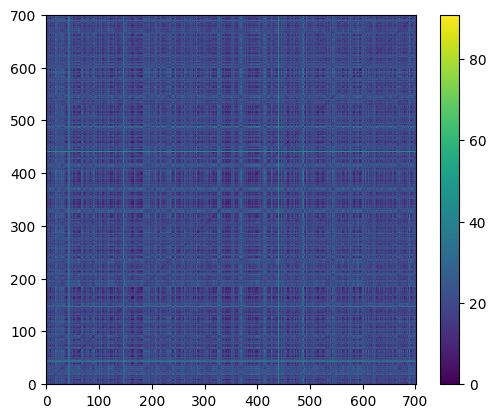

In [60]:
plt.imshow(vdistmat, origin='lower')
plt.colorbar()

In [61]:
Xv = np.vstack(gvecs['eCDRHL'].to_numpy())
X_, Y_ = [], []
ind = []

for i in range(N):
    a1 = Xv[i]
    for j in range(i):
        a2 = Xv[j]
        dg = np.linalg.norm(a1 - a2)
        X_.append(dg)
        Y_.append(vdistmat[i, j])
        ind.append((i, j))

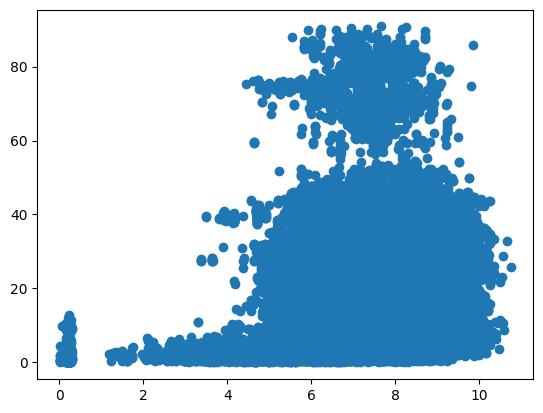

In [62]:
plt.scatter(X_, Y_)

In [65]:
from collections import Counter

dupind = [(ind[i], X_[i], Y_[i]) for i in range(len(X_)) if (X_[i]<1) & (Y_[i]>5)] 
# print('\n'.join(map(str, dupind)))
indlist = [x[0][0] for x in dupind] + [x[0][1] for x in dupind]
print(badids := [item for item, count in Counter(indlist).items() if count > 2])

[50, 91, 146, 199, 208, 258, 301, 335, 414, 591, 622, 29]


In [66]:
gvecs.drop(index=gvecs.iloc[badids, :].index.to_list(), inplace=True)
print(len(gvecs))
gvecs.to_json(PurePath(datadir, outfile3))


677


In [67]:
# Drop ECM structures with sugnificantly differ from X-Ray
# DIST 0.42800092697143555 7.501261287929377
# 408 305 IS-9A IS-9A 7YCL 8HHY ['H', 'L', 'D'] ['F', 'W', 'B']
gvecs.drop(index=gvecs[gvecs['pdbid'] == '8HHY'].index, inplace=True) 
# DIST 3.65395188331604 57.27163726074108
# 119 43 P5A-1B6 COVOX-45 7CZV 7PRY ['I', 'M', 'B'] ['F', 'G', 'E']
gvecs.drop(index=gvecs[gvecs['pdbid'] == '7CZV'].index, inplace=True)
# DIST 3.500866174697876 66.21690631486935
# 350 235 Asarnow_5A6 Liu_10-28 7KQB 7SI2 ['H', 'L', 'A'] ['G', 'F', 'C']
gvecs.drop(index=gvecs[gvecs['pdbid'] == '7KQB'].index, inplace=True)
# DIST 0.44726693630218506 3.343109008827203
# 158 86 FP-12A FP-12A 8HHX 7YCK ['H', 'I', 'C'] ['E', 'F', 'B']
gvecs.drop(index=gvecs[gvecs['pdbid'] == '8HHX'].index, inplace=True)

In [68]:
# Drop duplicates
gvecs.drop_duplicates(
    subset=[
        'CDRH1', 'CDRH2', 'CDRH3', 
        'CDRL1', 'CDRL2', 'CDRL3',
    ], keep='last', inplace=True)
print(len(gvecs))
gvecs.to_json(PurePath(datadir, outfile4))

372
